# YOLO
In yolo (you only look once) we will have B bounding boxes per pixel, and the pixels are large and cover the whole image.

The pixel in which the center of an object lies is responsible for detecting the object.

Each of the bounding boxes output is 5 numbers, (x,y) (the center, not corner) width, height, confidence.

Confidence is a prediction of IOU

Additionally, each cell predicts a probability distribution over class labels.




# Color module
We can use my attention mechanism to give some sort of a color module.

Say I have a variable number of colors N, and I want to map to a fixed number M.

We get M convolution filters.

We filter each image with each filter.  This gives an N x M array of images.

We then apply a softmax to it.  We then do matrix multiplication.



# TODO
use running mean batch norm

fix rotated bounding boxes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.collections import PolyCollection
# %matplotlib notebook
%matplotlib widget
from os import makedirs
from os.path import join
import os
import pickle
import time
from scipy.ndimage import gaussian_filter

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
import random
random.seed(seed)

user = 'abenneck'
# user = 'dtward'

import sys
sys.path.append('/home/abenneck/Desktop/yolo_model')

from yolo_help import iou

In [ ]:
resume = False # if True, will load a saved model
if user == 'abenneck':
    outdir = '/home/abenneck/Desktop/YOLO/yolo_saved_models_v01'
else:
    outdir = 'yolo_saved_models_v01'
modelname = 'modelsave.pt'
optimizername = 'optimizersave.pt'
lossname = 'loss.pt'
makedirs(outdir,exist_ok=True)

nclasses = 3
dtype = torch.float32

In [ ]:
from yolo_help import GroundTruthDataset


groundtruth = GroundTruthDataset(reproducible = True)

In [ ]:
from yolo_help import bbox_to_rectangles, imshow


I,bbox,cl = groundtruth[0]
fig,ax = plt.subplots()
#ax.imshow(I[0],cmap='gray')
imshow(I,ax,cmap='gray')
polys = bbox_to_rectangles(bbox,fc='none')
polys.set_edgecolor(plt.cm.jet(cl*255//(nclasses-1)))
ax.add_collection(polys)

In [ ]:
from yolo_help import VariableInputConv2d


layer = VariableInputConv2d(3)
fig,ax = plt.subplots(1,3)
I,bbox,cls = groundtruth[0]
imshow(I,ax[0])

r = torch.randperm(I.shape[0])
out1 = layer(torch.tensor(I,dtype=dtype)[None]).clone().detach()[0]
out2 = layer(torch.tensor(I,dtype=dtype)[r][None]).clone().detach()[0] 
imshow(out1,ax[1])
imshow(out2,ax[2])
# note the order of components doesn't matter

In [ ]:
from yolo_help import Net


net = Net()
out = net(torch.tensor(I[None],dtype=dtype))
out.shape

In [ ]:
from yolo_help import convert_data

# we need to transform the outputs into bounding boxes
# for this we need a parameterization
# now YOLO assumes a fixed size, which I don't want to do
# my parameterization will therefore be
# xyshift (a number between -0.5 and 0.5, relative to grid size)
# hwscale (relative to grid size, )

# so we need a function to do this transformation
# number of bounding boxes
B = net.B
stride = net.stride
bboxes,data = convert_data(out,B,stride)


fig,ax = plt.subplots()
x = torch.arange(out.shape[-1])*stride + (stride-1)/2
y = torch.arange(out.shape[-2])*stride + (stride-1)/2
YX = torch.stack(torch.meshgrid(y,x,indexing='ij'),0)
ax.imshow(I[0],cmap='gray')
ax.scatter(YX[1].ravel(),YX[0].ravel(),s=1,alpha=0.5)
x = bboxes[...,0]
y = bboxes[...,1]
w = bboxes[...,2]
h = bboxes[...,3]
c = data[...,-1]
predicted_rectangles = bbox_to_rectangles(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T,fc='none',ec='b',alpha=c.clone().detach()*0.5)
ax.add_collection(predicted_rectangles,)

true_rectangles = bbox_to_rectangles(bbox,fc='none',ec='r')
ax.add_collection(true_rectangles,)
fig.canvas.draw()

In [ ]:
from yolo_help import get_assignment_inds


# transform the true bounding boxes
# to do this first we need an assignment to a given cell
shape = out.shape
B = net.B

assignment_inds,ious = get_assignment_inds(bboxes,bbox,shape,stride,B)
bboxes_assigned = bboxes[assignment_inds]
x = bboxes_assigned[...,0]
y = bboxes_assigned[...,1]
w = bboxes_assigned[...,2]
h = bboxes_assigned[...,3]
c = data[assignment_inds,-1]
predicted_rectangles = bbox_to_rectangles(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T,fc='none',ec='g',alpha=c.clone().detach())
ax.add_collection(predicted_rectangles,)

In [ ]:
from yolo_help import get_reg_targets

# now that we have assignment inds and ious
# we also need the target regression parameters
shape = out.shape
stride = net.stride
B = net.B
    
shape = out.shape
stride = net.stride
B = net.B    
shiftx,shifty,scalex,scaley = get_reg_targets(assignment_inds,bbox,B,shape,stride)

In [ ]:
from yolo_help import train_yolo_model

if user == 'abenneck':
    J_path = '/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg'
else:
    J_path = '/home/dtward/data/AllenInstitute/ARA/section_000197_30800.jpeg'

nepochs = 1500
lr = 1e-4
cls_loss = torch.nn.CrossEntropyLoss(reduction='sum')
resume = True # if True, will load a saved model

modelname = 'modelsave.pt'
optimizername = 'optimizersave.pt'
lossname = 'loss.pt'

if user == 'abenneck':
#     if resume:
#         outdir = '/home/abenneck/Desktop/YOLO/yolo_saved_models_v01'
#     else:
    outdir = '/home/abenneck/Desktop/YOLO/yolo_saved_models_v02'
else:
    outdir = 'yolo_saved_models_v01'

net = train_yolo_model(nepochs, lr, cls_loss, outdir, modelname, optimizername, lossname, verbose=True, resume=resume,  J_path=J_path)

# Post-Processing

### Filter candidate bboxes (best_bbox_per_cell + NMS)

In [ ]:
from yolo_help import get_best_bounding_box_per_cell
from yolo_post_help import NMS, remove_low_conf_bboxes

outdir = '/home/abenneck/Desktop/yolo_model/data'
fname = 'all_bboxes.npz'

if os.path.exists(os.path.join(outdir, 'all_gt_bbox.pkl')):
    # Save the gt_bbox, pred_bbox, and pred_score info for downstream analysis
    with open(os.path.join(outdir,'all_gt_bbox.pkl'),'rb') as f:
        all_gt_bbox = pickle.load(f)
    with open(os.path.join(outdir,'all_pred_bbox.pkl'),'rb') as f:
        all_pred_bbox = pickle.load(f)
    with open(os.path.join(outdir,'all_scores.pkl'),'rb') as f:
        all_scores = pickle.load(f)
    print(f'Loaded 3 files from {outdir}')
else:
    all_pred_bbox = []
    all_scores = []
    all_gt_bbox = []
    nimages_pq = 10
    
    # bbox = [cx, cy, w, h, conf]
    for i, gt in enumerate(groundtruth):
        # Quantify the model's performance against 'nimages_pq' simulated gt images
        if i >= nimages_pq:
            break
            
        # Initialize gt objects 
        I,bbox,cls = gt
        print(f'=== Starting groundtruth[{i}] ({len(bbox)} bboxes) ===')
    
        # Get model outputs for the ith image in the gt dataset
        out = net(torch.tensor(I,dtype=dtype)[None])
        bboxes,data = convert_data(out,net.B,net.stride)
        scores = data[:,-1]
        print(f'{len(bboxes)} bboxes output from model')
        
        # Reduces # of guesses by factor of 2
        start = time.time()
        bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,scores.clone().detach(),net.B)
        print(f'{len(bboxes_)} bboxes after getting best bbox per cell; Finished in {time.time() - start:.2f}s')
    
        # Remove boudning boxes below some conf threshold
        start = time.time()
        bboxes, scores_ = remove_low_conf_bboxes(bboxes_, scores_)
        print(f'{len(bboxes_)} bboxes after removing low conf bboxes; Finished in {time.time() - start:.2f}s')
        
        # Perform NMS on filtered guesses (Reduce by a factor of ~2
        start = time.time()
        bboxes_,scores_ = NMS(bboxes_, scores_, nms_threshold = 0.9)
        print(f'{len(bboxes_)} bboxes after NMS; Finished in {time.time() - start:.2f}s\n')
        
        # Append outputs from current image to all outputs for downstream performance quantification
        all_gt_bbox.append(bbox)
        all_pred_bbox.append(bboxes_)
        all_scores.append(scores_)

    # Save the gt_bbox, pred_bbox, and pred_score info for downstream analysis
    with open(os.path.join(outdir,'all_gt_bbox.pkl'),'wb') as f:
        pickle.dump(all_gt_bbox,f)
    with open(os.path.join(outdir,'all_pred_bbox.pkl'),'wb') as f:
        pickle.dump(all_pred_bbox,f)
    with open(os.path.join(outdir,'all_scores.pkl'),'wb') as f:
        pickle.dump(all_scores,f)
    print(f'Saved output .pkl files to {outdir}')

### Compare GT bounding boxes with filtered estimated bounding boxes

In [ ]:
I,bbox,cl = groundtruth[0]
fig,axs = plt.subplots(1,2)
fig.set_size_inches(8,4)

imshow(I,axs[0],cmap='gray')
polys = bbox_to_rectangles(np.asarray(bbox),fc='none')
polys.set_edgecolor(plt.cm.jet(cl*255//(nclasses-1)))
axs[0].add_collection(polys)
axs[0].set_title('Ground truth')

imshow(I,axs[1],cmap='gray')
polys = bbox_to_rectangles(np.asarray(bboxes_),fc='none')
# polys.set_edgecolor(plt.cm.jet(cl*255//(nclasses-1)))
axs[1].add_collection(polys)
axs[1].set_title('Estimate')

## PR Curve Generation

Loaded data stored at /home/abenneck/Desktop/yolo_model/data/all_pr_curves.npz. Last iou was 0.95


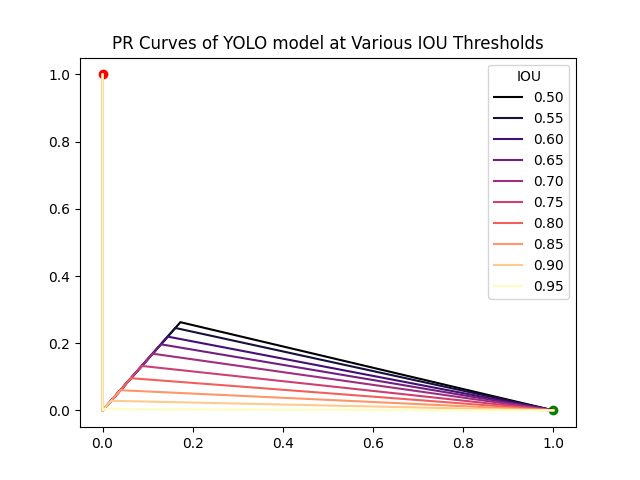

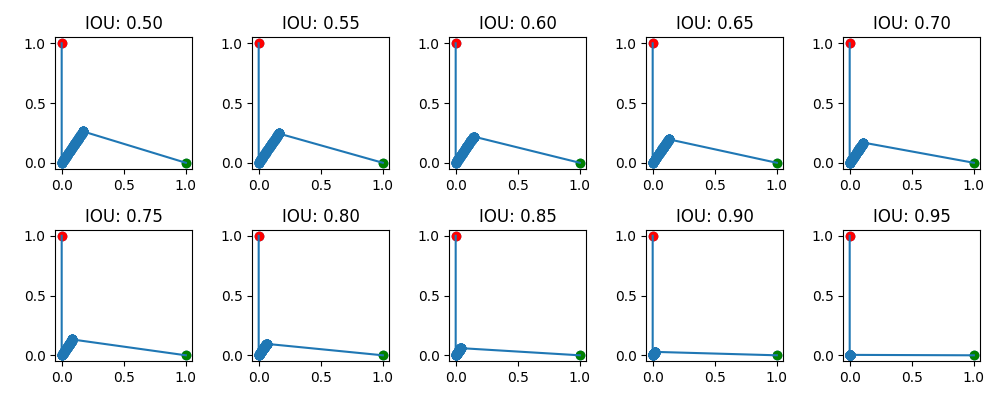

mAP: 0.07067238912732475


In [47]:
import importlib as imp
import yolo_post_help
imp.reload(yolo_post_help)
from yolo_post_help import compute_pr_curves, plot_pr_curves, get_mAP

outdir_pr = '/home/abenneck/Desktop/yolo_model/data'
out = compute_pr_curves(all_gt_bbox, all_pred_bbox, all_scores, outdir_pr, verbose = True)
fig, axs = plot_pr_curves(out)
fig, axs = plot_pr_curves(out, condense = False)
mAP = get_mAP(out)
print(f'mAP: {mAP}')

In [ ]:
total = 0
for pb in all_pred_bbox:
    print(len(pb))
    total += len(pb)
print(total)

In [ ]:
total = 0
for i, gt_bb in enumerate(all_pred_bbox):
    total += len(gt_bb)
    print(i,':',len(gt_bb))
print(total)

In [ ]:
import os
fname = 'all_pr_curves.npz'
pr_data = np.load(os.path.join(outdir_pr, fname))
print([k for k in pr_data])
print(len(pr_data['data'][2]))